# Imputation Comparison

[![open in colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ing-bank/probatus/blob/master/docs/tutorials/nb_imputation_comparison.ipynb)

In [1]:
%matplotlib inline
%config Completer.use_jedi = False
%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_row', 500)
pd.set_option('display.max_colwidth', 200)

This notebook explains how the `CompareImputationStrategies` class works in `probatus`
First let us import the class and other required classes.

In [2]:
from probatus.missing.imputation import CompareImputationStrategies
from probatus.utils.missing_helpers import generate_MCAR
import pandas as pd 
from sklearn.datasets import make_classification
import lightgbm as lgb 
import xgboost as xgb 
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.experimental import enable_iterative_imputer  
from sklearn.impute import KNNImputer,SimpleImputer,IterativeImputer
from feature_engine.imputation import RandomSampleImputer
from sklearn.preprocessing import KBinsDiscretizer
import string
import fire

Let's create some data on which we want to apply the various imputation strategies.
We will create a dataset with both numerical and categorical variables.

Currently `CompareImputationStrategies` supports any scikit learn compatible imputation strategies.
For categorical columns  `OneHotEncoder` is applied internally by default. 
The user supplied imputation strategies are applied to numerical columns only. Support for user supplied imputation strategies for categorical columns can be added in the future releases.

In [3]:
def get_data(n_samples,n_numerical,n_category):
        """
        Returns a dataframe with numerical and categorical features.
        """
        no_vars = n_numerical + n_category
       
        X,y = make_classification(
            n_samples=n_samples, 
            n_features=no_vars, 
            random_state=123,
            class_sep=0.3,
            flip_y=0.3)

        binner = KBinsDiscretizer(n_bins=5, encode='ordinal', strategy="quantile")
        X[:,n_numerical:] = binner.fit_transform(X[:,n_numerical:])

        #Add column names.
        X = pd.DataFrame(X, columns=["f_"+str(i) for i in range(0,no_vars)])

        # Efficiently map values to another value with .map(dict)
        X.iloc[:,n_numerical:] = X.iloc[:,n_numerical:].apply(
            lambda x: x.map({i:letter for i,letter in enumerate(string.ascii_uppercase)}))
        
        return X,y

X,y = get_data(n_samples=1000,n_numerical=10,n_category=5)
print(f"Shape of X,y : {X.shape},{y.shape}")


Shape of X,y : (1000, 15),(1000,)


Add missing values to the dataset. `generate_MCAR` method randomly adds missing values to the dataset.

In [4]:
X_missing = generate_MCAR(X,missing=0.2)
X_missing.isnull().mean()

f_0     0.187
f_1     0.196
f_2     0.196
f_3     0.195
f_4     0.221
f_5     0.173
f_6     0.203
f_7     0.201
f_8     0.222
f_9     0.199
f_10    0.211
f_11    0.210
f_12    0.186
f_13    0.184
f_14    0.195
dtype: float64

## Imputation Strategies

Create a dictionary with all the strategies to compare. Also, create a classifier that you want to use to evaluate various strategies.
If the model supports handling of missing features by default then the model performance on an unimputed dataset is calculated.
The model performance against the unimputed dataset can be found in `Model Imputation` results.

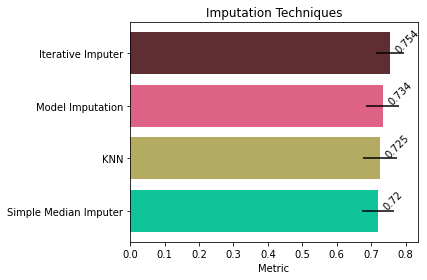

In [5]:
strategies = {
    'KNN' : KNNImputer(n_neighbors=3),
    'Simple Median Imputer' : SimpleImputer(strategy='median',add_indicator=True),
    'Iterative Imputer'  : IterativeImputer(add_indicator=True,n_nearest_features=5,
    sample_posterior=True)
    }
clf = lgb.LGBMClassifier()
cmp = CompareImputationStrategies(clf=clf,strategies=strategies,cv=10)
cmp.fit_compute(X_missing,y)
cmp.plot()

As can be seen with the above plot that, the `Iterative Imputer` strategy provide better model performance.

However if the model does not support missing values by default, only the inputation strategies are calculated.This can be indicated by setting the `model_na_support` parameter to `False`.


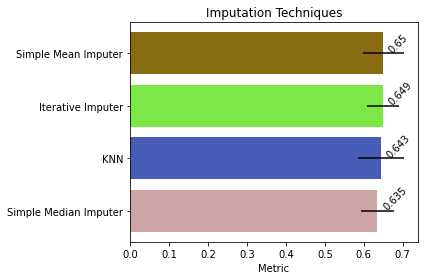

In [9]:
strategies = {
    'KNN' : KNNImputer(n_neighbors=3),
    'Simple Median Imputer' : SimpleImputer(strategy='median',add_indicator=True),
    'Simple Mean Imputer' : SimpleImputer(strategy='mean',add_indicator=False),
    'Iterative Imputer'  : IterativeImputer(add_indicator=True,n_nearest_features=5,
    sample_posterior=True)
    }
clf = LogisticRegression()
cmp = CompareImputationStrategies(clf=clf,strategies=strategies,cv=10,model_na_support=False)
cmp.fit_compute(X_missing,y)
cmp.plot()

### Scikit Learn Compatible Imputers. 

You can also use any other scikit-learn compatible imputer as an imputing strategy.
eg. [feature engine](https://feature-engine.readthedocs.io/en/latest/index.html) library provides a host of other imputing stratgies as well. You can pass them for comparision. Let us try the `RandomSampleImputer`. You can read more about it [here](https://feature-engine.readthedocs.io/en/latest/imputation/RandomSampleImputer.html)

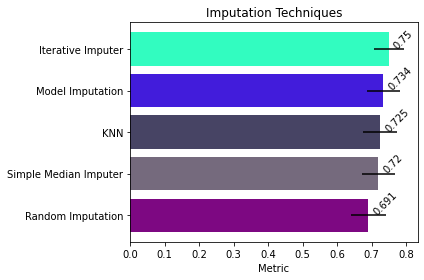

In [7]:
strategies = {
    'KNN' : KNNImputer(n_neighbors=3),
    'Simple Median Imputer' : SimpleImputer(strategy='median',add_indicator=True),
    'Iterative Imputer'  : IterativeImputer(add_indicator=True,n_nearest_features=5,
    sample_posterior=True),
    'Random Imputation' : RandomSampleImputer()
    }
clf = lgb.LGBMClassifier()
cmp = CompareImputationStrategies(clf=clf,strategies=strategies,cv=10)
cmp.fit_compute(X_missing,y)
cmp.plot()

Unfortunately in this case, the `RandomSampleImputer` does not provide any improvements over the existing strategies. 